#Trabajo Practico 4

Pinto, Nicolas \\
Padron: 105064

La tarea consiste en construir un clasificador que dada una imagen devuelva la categoría a la que corresponde. ¿Qué tan bien funciona la validación?

##Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from matplotlib import pyplot
from PIL import Image

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

import os
import os.path

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Datasets

In [ ]:
!unzip gdrive/My\ Drive/Datasets\ TP4/silkroad2_images.zip  > /dev/null

In [ ]:
silkroad_items = pd.read_csv('gdrive/My Drive/Datasets TP4/silkroad2_csvs.zip (Unzipped Files)/silkroad_items.csv')

In [ ]:
image_folder = '/content/images_by_id/'

##Preparo el dataset

In [ ]:
dictionary = {}
for photo in os.listdir(image_folder):         
  image_path= os.path.join(image_folder, photo)         
  image= Image.open(image_path) 
  image = np.asarray(Image.open(image_path), dtype='uint8')
  if image.shape == (135, 180, 3):
    name = float(photo.replace(".jpg", ""))
    dictionary[name] = image
  del(image)

In [ ]:
filtered_by_id = silkroad_items.loc[silkroad_items['image_id'].isin(dictionary), :].copy()
filtered_images = filtered_by_id[['category','image_id']].copy()
del(filtered_by_id)

Las fotos de alcohol no corresponden a esa categoria y las de other tambien las saque porque quiero calificar cosas en concreto

In [ ]:
filtered_images = filtered_images[filtered_images['category'] != "Alcohol"].copy()
filtered_images = filtered_images[filtered_images['category'] != "Other"].copy()

In [ ]:
categories_frecuency = filtered_images['category'].value_counts()
top_frecuency = categories_frecuency.head(6)
df_frecuency = pd.DataFrame(top_frecuency)
df_frecuency.reset_index(inplace = True)

In [ ]:
top_frecuency = df_frecuency['index'].to_list()

In [ ]:
final_df = filtered_images.loc[(filtered_images['category'].isin(top_frecuency)) ,:].copy()

In [ ]:
final_df = final_df.sample(frac = 1, random_state = 2)

##Divido el dataset

In [ ]:
train_len = int((final_df.shape[0])*0.95)
test_len = int((final_df.shape[0])-train_len)

In [ ]:
train_set = final_df.head(train_len).copy()
test_set = final_df.tail(test_len).copy()

In [ ]:
test_set.drop_duplicates(inplace= True)
train_set.drop_duplicates(inplace=True)

In [ ]:
train_set.shape

(11322, 2)

In [ ]:
test_set.shape

(3226, 2)

In [ ]:
del(top_frecuency)

In [ ]:
del(silkroad_items)

##Encoding

In [ ]:
train_set['image_values'] = train_set['image_id'].map(dictionary)
train_set

,category,image_id,image_values
192459,Weed,27160.0,"[[[252, 253, 255], [252, 253, 255], [252, 253,..."
375116,Ecstasy,42878.0,"[[[123, 139, 112], [110, 126, 100], [99, 113, ..."
332196,MDMA,19473.0,"[[[140, 127, 111], [141, 127, 114], [138, 125,..."
391888,Ecstasy,46178.0,"[[[201, 199, 210], [201, 199, 210], [200, 200,..."
318530,Weed,23067.0,"[[[59, 61, 60], [57, 59, 58], [62, 66, 65], [7..."
...,...,...,...
234945,Cannabis,48126.0,"[[[158, 157, 137], [157, 156, 136], [157, 156,..."
18018,Stimulants,19458.0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
374624,Cannabis,52513.0,"[[[197, 189, 187], [197, 189, 187], [198, 190,..."
58005,Cannabis,27858.0,"[[[51, 39, 27], [51, 39, 27], [51, 39, 27], [5..."


In [ ]:
test_set['image_values'] = test_set['image_id'].map(dictionary)
test_set

,category,image_id,image_values
122128,MDMA,36832.0,"[[[242, 203, 164], [245, 206, 167], [247, 207,..."
369375,Cocaine,38596.0,"[[[18, 19, 14], [18, 19, 14], [18, 19, 14], [1..."
319739,Stimulants,51169.0,"[[[43, 102, 74], [50, 107, 72], [50, 107, 66],..."
233357,Cannabis,45858.0,"[[[194, 180, 169], [197, 183, 172], [200, 186,..."
112978,Weed,23647.0,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."
...,...,...,...
153485,Weed,8504.0,"[[[83, 82, 61], [84, 83, 62], [80, 77, 58], [7..."
212103,MDMA,45028.0,"[[[184, 189, 227], [186, 192, 228], [186, 192,..."
158453,Weed,19188.0,"[[[241, 244, 233], [251, 254, 245], [245, 250,..."
355993,Ecstasy,45041.0,"[[[131, 128, 97], [163, 158, 126], [200, 192, ..."


In [ ]:
del(dictionary)

In [ ]:
column_one_hot = []
column_one_hot.append('category')

In [ ]:
onehotencoder = OneHotEncoder()
y_train = onehotencoder.fit_transform(train_set['category'].values.reshape(-1,1)).toarray()

In [ ]:
y_test = onehotencoder.fit_transform(test_set['category'].values.reshape(-1,1)).toarray()
y_test

array([[0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [ ]:
x_train = train_set['image_values'].tolist()

In [ ]:
x_train = np.array(x_train)

In [ ]:
x_train.shape

(11322, 135, 180, 3)

In [ ]:
y_train.shape

(11322, 6)

In [ ]:
x_test = test_set['image_values'].tolist()
x_test = np.array(x_test)
x_test.shape

(3226, 135, 180, 3)

In [ ]:
x_test.shape

(3226, 135, 180, 3)

In [ ]:
y_test.shape

(3226, 6)

In [ ]:
del(final_df)

##CNN

###Modelo

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from keras.models import Sequential


from sklearn.model_selection import train_test_split

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,random_state=1)

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

model= Sequential()
model.add(Conv2D(kernel_size=(3,3), filters=32, activation='tanh', input_shape=(135,180,3,)))
model.add(Conv2D(filters=10,kernel_size = (3,3),activation='tanh'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=10,kernel_size = (3,3),activation='tanh'))
model.add(MaxPool2D(3,3))
model.add(Conv2D(filters=10,kernel_size = (3,3),activation='tanh'))

model.add(Flatten())

model.add(Dense(30,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(20,activation='relu'))
model.add(Dense(6,activation = 'softmax'))
    
model.compile(
              loss='categorical_crossentropy', 
              metrics=['acc'],
              optimizer= keras.optimizers.Adam(learning_rate=0.0005)
             )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 133, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 131, 176, 10)      2890      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 65, 88, 10)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 86, 10)        910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 28, 10)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 19, 26, 10)        9

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_acc', patience=4, restore_best_weights=True)
history = model.fit(x_train,y_train,epochs=40,batch_size=64 , callbacks=[early_stopping],validation_data=(x_val,y_val))

Epoch 1/40
133/133 [==============================] - 416s 3s/step - loss: 1.6615 - acc: 0.2864 - val_loss: 1.5412 - val_acc: 0.3642
Epoch 2/40
133/133 [==============================] - 400s 3s/step - loss: 1.4542 - acc: 0.3952 - val_loss: 1.3445 - val_acc: 0.4546
Epoch 3/40
133/133 [==============================] - 405s 3s/step - loss: 1.3005 - acc: 0.4667 - val_loss: 1.1923 - val_acc: 0.5224
Epoch 4/40
133/133 [==============================] - 404s 3s/step - loss: 1.1364 - acc: 0.5613 - val_loss: 1.0670 - val_acc: 0.6079
Epoch 5/40
133/133 [==============================] - 400s 3s/step - loss: 0.9503 - acc: 0.6469 - val_loss: 0.9572 - val_acc: 0.6627
Epoch 6/40
133/133 [==============================] - 398s 3s/step - loss: 0.7954 - acc: 0.7082 - val_loss: 0.8362 - val_acc: 0.7199
Epoch 7/40
133/133 [==============================] - 396s 3s/step - loss: 0.6830 - acc: 0.7564 - val_loss: 0.7853 - val_acc: 0.7425
Epoch 8/40
133/133 [==============================] - 396s 3s/step - 

In [ ]:
import pickle
with open('data_backup', 'wb') as model_backup_file:
  pickle.dump(history, model_backup_file)

INFO:tensorflow:Assets written to: ram://20ad8b73-a940-4f6f-a29f-a0364139dda9/assets


###Graphs

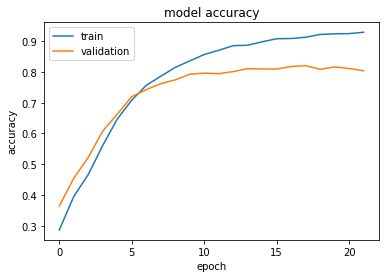

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

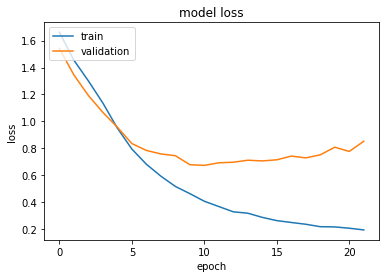

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
evaluate = model.evaluate(x_val,y_val)
print(evaluate)

89/89 [==============================] - 32s 362ms/step - loss: 0.7302 - acc: 0.8202
[0.7301729321479797, 0.8202048540115356]


###Testing

In [ ]:
output = { 0:'Cannabis',1:'Cocaine',2:'Ecstasy',3:'MDMA',4:'Stimulants',5:'Weed'}

In [ ]:
preds = model.predict(x_test)

In [ ]:
preds = np.argmax(preds, axis=1)
preds

array([3, 1, 4, ..., 5, 2, 2])

In [ ]:
y_test = np.argmax(y_test, axis=1)
y_test

array([3, 1, 4, ..., 5, 2, 2])

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       473
           1       0.94      0.91      0.92       372
           2       0.92      0.92      0.92       656
           3       0.92      0.88      0.90       441
           4       0.91      0.94      0.93       659
           5       0.94      0.95      0.95       625

    accuracy                           0.93      3226
   macro avg       0.93      0.92      0.92      3226
weighted avg       0.93      0.93      0.93      3226



In [ ]:
accuracy_score(y_test, preds)

0.9252944823310602

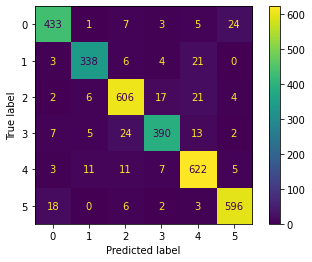

In [ ]:
matrix = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(matrix)
disp.plot()

In [ ]:
print("Predicted :- ",output[preds[10]])
print("Real :- ",output[y_test[10]])

Predicted :-  Weed
Real :-  Weed


In [ ]:
y_test[10]

5

In [ ]:
test_set.iloc[10,1]

26490.0

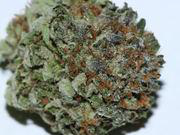

In [ ]:
Image.open("/content/images_by_id/26490.jpg")